In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import *
from datafs import *
import math

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader as DL
import torch.nn.functional as F
import torch.nn.init as init
torch.cuda.empty_cache()

In [3]:
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

Using CUDA


In [4]:
# data_f = './'
# train_path = data_f + 'DIV2K/DIV2K_valid_HR/'
# # train_path = data_f + 'Images/'
# test__path = data_f + 'Test/Set5/'

In [5]:
scale =3

In [6]:
train_set = DataSetF(train_path,scale) ## input Image folder and scale
test_set =  DataSetF(test__path,scale)

In [7]:
train_loader = DL(train_set) ## input Image folder and scale
test_loader =  DL(test_set)

In [8]:
## UTILITY FUNCTIONS
def Test_with_psnr(model):
    avg_psnr = 0
    for batch in test_loader:
        img,label = batch[0].to(device),batch[1].to(device)
        out = model(img)
        psnr = PSNR(out,label)
        avg_psnr += psnr
    print("Avg. PSNR :",{avg_psnr / len(test_loader)}, "dB.")
    return avg_psnr / len(test_loader)
    
def PSNR(imageTensor,labelTensor):
    criterion = nn.MSELoss()
    loss = criterion(imageTensor,labelTensor)
    psnr = 10*math.log10(1/loss.item())
    return psnr
def PSNR_img(image,label):
    assert image.size==label.size
    tensor = transforms.ToTensor()
    imageTensor = tensor(image)
    labelTensor = tensor(label)
    return PSNR(imageTensor,labelTensor)

In FSRCNN, 5 main steps as in the figure with more convolutions are involved:

    1.Feature Extraction: Bicubic interpolation in previous SRCNN is replaced by 5×5 conv.
    2.Shrinking: 1×1 conv is done to reduce the number of feature maps from d to s where s<<d.
    3.Non-Linear Mapping: Multiple 3×3 layers are to replace a single wide one
    4.Expanding: 1×1 conv is done to increase the number of feature maps from s to d.
    5.Deconvolution: 9×9 filters are used to reconstruct the HR image.

In [9]:
class FSRCNN(nn.Module):
    def __init__(self,upscale_factor):
        super(FSRCNN, self).__init__()
        # Feature extraction
        self.feature_extraction = nn.Sequential(
                      nn.Conv2d(1, 56, (5, 5), (1, 1), (2, 2)),
                      nn.PReLU(56)
                      )
        # Shrinking
        self.shrink = nn.Sequential(
                      nn.Conv2d(56, 12, (1, 1), (1, 1), (0, 0)),
                      nn.PReLU(12)
                      )
        
        # Mapping layer.
        self.map = nn.Sequential(
                      nn.Conv2d(12, 12, (3, 3), (1, 1), (1, 1)),
                      nn.PReLU(12),
                      nn.Conv2d(12, 12, (3, 3), (1, 1), (1, 1)),
                      nn.PReLU(12),
                      nn.Conv2d(12, 12, (3, 3), (1, 1), (1, 1)),
                      nn.PReLU(12),
                      nn.Conv2d(12, 12, (3, 3), (1, 1), (1, 1)),
                      nn.PReLU(12)
                      )

        # Expanding layer.
        self.expand = nn.Sequential(
                      nn.Conv2d(12, 56, (1, 1), (1, 1), (0, 0)),
                      nn.PReLU(56)
                      )

        # Deconvolution layer.
        self.deconv = nn.ConvTranspose2d(56, 1, (9, 9), (upscale_factor, upscale_factor), (4, 4), (upscale_factor - 1, upscale_factor - 1))

        # Initialize model weights.
        self._initialize_weights()

        
#     def forward_feed(self,x):
    def __call__(self,x):
        out = self.feature_extraction(x)
        out = self.shrink(out)
        out = self.map(out)
        out = self.expand(out)
        out = self.deconv(out)
        return out
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2 / (m.out_channels * m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)

        nn.init.normal_(self.deconv.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.deconv.bias.data)

In [10]:
def Enhance_Image_FSRCNN(model,image,multichannel = False):
    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
    converter = torch.load(model).to(device)
    img = Image.open(image) ###low Res Image not interpolated
    img = img.convert('YCbCr')
    # img = myTransforms(scale).BicubicInterpolation(img)  #We don't need to use bicubic for FSRCNN
    Y,Cb,Cr = img.split()
    tensor_img = transforms.ToTensor()
    
    channel1 = tensor_img(Y).view(1,-1,Y.size[1],Y.size[0]).to(device)
    out_channel1 = converter(channel1)
    out_channel1 = out_channel1.cpu()
    Y_enhanced =  np.array(out_channel1[0].detach())*255.
    Y_enhanced = Y_enhanced.clip(0,255)
    Y_enhanced = Image.fromarray(np.uint8(Y_enhanced[0]))
    
    channel2 = tensor_img(Cb).view(1,-1,Cb.size[1],Cb.size[0]).to(device)
    out_channel2 = converter(channel2)
    out_channel2 = out_channel2.cpu()
    Cb_enhanced =  np.array(out_channel2[0].detach())*255.
    Cb_enhanced = Cb_enhanced.clip(0,255)
    Cb_enhanced = Image.fromarray(np.uint8(Cb_enhanced[0]))
    
    channel3 = tensor_img(Cr).view(1,-1,Cr.size[1],Cr.size[0]).to(device)
    out_channel3 = converter(channel3)
    out_channel3 = out_channel3.cpu()
    Cr_enhanced =  np.array(out_channel3[0].detach())*255.
    Cr_enhanced = Cr_enhanced.clip(0,255)
    Cr_enhanced = Image.fromarray(np.uint8(Cr_enhanced[0]))
    
    res = Image.merge('YCbCr',[Y_enhanced,Cb_enhanced,Cr_enhanced]).convert('RGB')
    return res

In [11]:
def TrainFSR(model,number_of_epoch):
    lsv=[]
    psnrval=[]
    
    model = model.to(device)
    criterion = nn.MSELoss()
#     criterion = MS_SSIM_L1_LOSS()
    optimizer = optim.Adam(  # we use Adam instead of SGD like in the paper, because it's faster
    [
        {"params": model.feature_extraction.parameters()},
        {"params": model.shrink.parameters()},
        {"params": model.map.parameters()},
        {"params": model.expand.parameters()},
        {"params": model.deconv.parameters(), "lr": 1e-4},
    ], lr=1e-4,
    )
    for epoch in range(number_of_epoch):
        loss_in_epoch = 0
        for iteration,batch in enumerate(train_loader):
            img,label = batch[0].to(device),batch[1].to(device)
            
            optimizer.zero_grad()
            
            out_img = model(img)
#             print(label.shape,out_img.shape)
            loss = criterion(out_img,label)
            loss.backward()
            optimizer.step()
            loss_in_epoch += loss.item()
            
        print(f"Epoch {epoch}. Training loss: {loss_in_epoch/ len(train_loader)}")
        lsv += [loss_in_epoch/ len(train_loader)]
        psnrval += [Test_with_psnr(model)]
    torch.save(model,f"fsrcnn_model_scale3.pth")
    return lsv,psnrval

In [12]:
len(train_set)

7229

In [13]:
# model = FSRCNN(scale)
# lsv,psnrval = TrainFSR(model,500)

Epoch 0. Training loss: 0.017531246491184968
Avg. PSNR : {29.32641459709299} dB.
Epoch 1. Training loss: 0.011908831026900013
Avg. PSNR : {30.419484159686228} dB.
Epoch 2. Training loss: 0.011549264564329871
Avg. PSNR : {30.821210713489155} dB.
Epoch 3. Training loss: 0.011428692541833412
Avg. PSNR : {30.96621776991328} dB.
Epoch 4. Training loss: 0.011373196672591042
Avg. PSNR : {30.847956575758094} dB.
Epoch 5. Training loss: 0.011334240733112889
Avg. PSNR : {31.116563777276365} dB.
Epoch 6. Training loss: 0.011306144576693499
Avg. PSNR : {31.05673787388364} dB.
Epoch 7. Training loss: 0.011284288939400087
Avg. PSNR : {31.219638512095656} dB.
Epoch 8. Training loss: 0.011264317265704775
Avg. PSNR : {31.131262035274528} dB.
Epoch 9. Training loss: 0.011242241681994251
Avg. PSNR : {31.39924695292653} dB.
Epoch 10. Training loss: 0.011222245619744707
Avg. PSNR : {31.429842450558397} dB.
Epoch 11. Training loss: 0.011201451695796312
Avg. PSNR : {31.419835224930104} dB.
Epoch 12. Training

Epoch 100. Training loss: 0.01076771337856517
Avg. PSNR : {32.644145725301485} dB.
Epoch 101. Training loss: 0.0107662052551648
Avg. PSNR : {32.64249098694334} dB.
Epoch 102. Training loss: 0.01076498616675248
Avg. PSNR : {32.63362462905933} dB.
Epoch 103. Training loss: 0.010763452600299098
Avg. PSNR : {32.66592568425888} dB.
Epoch 104. Training loss: 0.010762243031909653
Avg. PSNR : {32.665625106765994} dB.
Epoch 105. Training loss: 0.010761039096999337
Avg. PSNR : {32.6751978947628} dB.
Epoch 106. Training loss: 0.010759553927557345
Avg. PSNR : {32.66796250100121} dB.
Epoch 107. Training loss: 0.010758154840702113
Avg. PSNR : {32.70625473984211} dB.
Epoch 108. Training loss: 0.010757133708810396
Avg. PSNR : {32.68761569307142} dB.
Epoch 109. Training loss: 0.010755906340191738
Avg. PSNR : {32.713377856589} dB.
Epoch 110. Training loss: 0.010754773846416854
Avg. PSNR : {32.72947366772183} dB.
Epoch 111. Training loss: 0.010753457509705694
Avg. PSNR : {32.72114471688151} dB.
Epoch 112

Epoch 199. Training loss: 0.010669953923220666
Avg. PSNR : {32.74019067743828} dB.
Epoch 200. Training loss: 0.010669087729132122
Avg. PSNR : {32.73754024590123} dB.
Epoch 201. Training loss: 0.01066818350000132
Avg. PSNR : {32.77729908295738} dB.
Epoch 202. Training loss: 0.010667410358915242
Avg. PSNR : {32.767813631475256} dB.
Epoch 203. Training loss: 0.01066681040265381
Avg. PSNR : {32.767481692638825} dB.
Epoch 204. Training loss: 0.010665986214241979
Avg. PSNR : {32.78261458635431} dB.
Epoch 205. Training loss: 0.010665174896793589
Avg. PSNR : {32.767381329760944} dB.
Epoch 206. Training loss: 0.010664245351140881
Avg. PSNR : {32.76239680255377} dB.
Epoch 207. Training loss: 0.010663448067647154
Avg. PSNR : {32.77572703302243} dB.
Epoch 208. Training loss: 0.010663153390529142
Avg. PSNR : {32.76678936134715} dB.
Epoch 209. Training loss: 0.010662169236548164
Avg. PSNR : {32.78179281826546} dB.
Epoch 210. Training loss: 0.010661119963181847
Avg. PSNR : {32.73520432402104} dB.
Epo

Epoch 298. Training loss: 0.01060062078432562
Avg. PSNR : {32.735684567051905} dB.
Epoch 299. Training loss: 0.01060007424489854
Avg. PSNR : {32.73483506094027} dB.
Epoch 300. Training loss: 0.010599839398197142
Avg. PSNR : {32.726105770625644} dB.
Epoch 301. Training loss: 0.010599265158738954
Avg. PSNR : {32.73119016037506} dB.
Epoch 302. Training loss: 0.010598978852039496
Avg. PSNR : {32.73293903507481} dB.
Epoch 303. Training loss: 0.010598135471677553
Avg. PSNR : {32.743709469098825} dB.
Epoch 304. Training loss: 0.010598020536632644
Avg. PSNR : {32.73729067030404} dB.
Epoch 305. Training loss: 0.010597300786721567
Avg. PSNR : {32.7283640686491} dB.
Epoch 306. Training loss: 0.010596760011098709
Avg. PSNR : {32.70113826737973} dB.
Epoch 307. Training loss: 0.010596226674333289
Avg. PSNR : {32.7142625251346} dB.
Epoch 308. Training loss: 0.010595811432619595
Avg. PSNR : {32.730875349694216} dB.
Epoch 309. Training loss: 0.010595139008097365
Avg. PSNR : {32.70426259922856} dB.
Epoc

Epoch 397. Training loss: 0.010550385568931203
Avg. PSNR : {32.72899252335371} dB.
Epoch 398. Training loss: 0.010549818322079184
Avg. PSNR : {32.69461126950072} dB.
Epoch 399. Training loss: 0.010549420106633208
Avg. PSNR : {32.69804622220534} dB.
Epoch 400. Training loss: 0.010548952502314454
Avg. PSNR : {32.6861006831527} dB.
Epoch 401. Training loss: 0.010548377676433608
Avg. PSNR : {32.68948843694449} dB.
Epoch 402. Training loss: 0.010548084767075626
Avg. PSNR : {32.70854577876298} dB.
Epoch 403. Training loss: 0.01054775574409787
Avg. PSNR : {32.70188734279975} dB.
Epoch 404. Training loss: 0.010547605642019021
Avg. PSNR : {32.699184821357065} dB.
Epoch 405. Training loss: 0.010547029142226074
Avg. PSNR : {32.71025816307574} dB.
Epoch 406. Training loss: 0.010546946831471234
Avg. PSNR : {32.705066827559975} dB.
Epoch 407. Training loss: 0.010546570314263967
Avg. PSNR : {32.69166043158128} dB.
Epoch 408. Training loss: 0.01054659545891817
Avg. PSNR : {32.68043361079659} dB.
Epoch

Epoch 496. Training loss: 0.010506870259175002
Avg. PSNR : {32.784165711622286} dB.
Epoch 497. Training loss: 0.010506368230250291
Avg. PSNR : {32.84533863598113} dB.
Epoch 498. Training loss: 0.010506323977537145
Avg. PSNR : {32.84488216026081} dB.
Epoch 499. Training loss: 0.010506238448210267
Avg. PSNR : {32.792514890405286} dB.


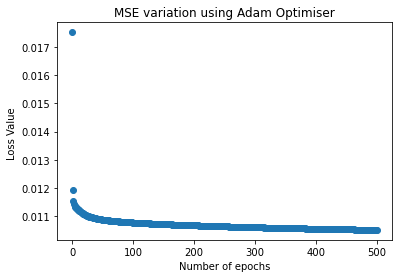

In [14]:
# plt.scatter(range(len(lsv)),lsv)
# plt.xlabel("Number of epochs")
# plt.ylabel("Loss Value ")
# plt.title("MSE variation using Adam Optimiser")
# plt.savefig("Variation of MSE")

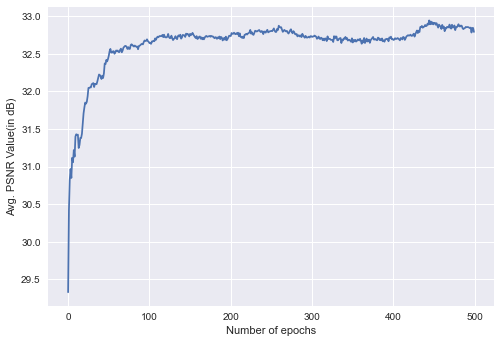

In [15]:
# plt.style.use('seaborn')
# plt.plot(psnrval)
# plt.xlabel("Number of epochs")
# plt.ylabel("Avg. PSNR Value(in dB)")
# plt.savefig("Variation of PSNR")

In [16]:
# model = 'fsrcnn_model_scale3.pth'
# image = 'bird_GT.bmp'

# low_res = myTransforms(scale).downscale(Image.open(image))
# low_res.save('Low_Res_FSRCNN.bmp')
# interpolated_img = myTransforms(scale).BicubicInterpolation(low_res)
# interpolated_img.save("Interpolated_FSRCNN.bmp")
# device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


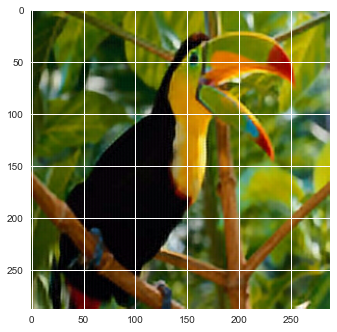

In [17]:
# img = Enhance_Image_FSRCNN(model,'Low_Res_FSRCNN.bmp',2)
# img.save('Final_image_FSRCNN.bmp')
# plt.imshow(img)

In [18]:
low_res.size

(96, 96)

In [19]:
interpolated_img.size

(288, 288)

In [20]:
img.size

(288, 288)

In [21]:
# Image.open(image).size

(288, 288)

In [22]:
# PSNR_img(interpolated_img,Image.open(image))

30.60927961185257

In [23]:
# PSNR_img(Image.open(image),img)

31.38802935686313

In [24]:
# Image.open(image).size,img.size

((288, 288), (288, 288))